In [114]:
import csv
import numpy as np
from math import *

obs = [] #array to store observed temperatures
labels = [] #array to store true class labels
posteriors = [] #array to store posteriors from all classes
activations = [] #array to store activations from all classes
R = 0 #Observation noise variance

#Retrive temperatures and true class labels from csv file
with open('pour_martin_ix70_iy115_iz26.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    l = 0
    for row in spamreader:
        if l == 0:
            l = 1 #first row is titles, we skip it
        else:
            arr = row[0].split('\t')
            obs.append(float(arr[1]))
            labels.append(int(arr[2]))
            tmpP= []
            tmpA = []
            for k in range(4):
                tmpP.append(float(arr[3+k]))
                tmpA.append(float(arr[7+k]))
            posteriors.append(tmpP)
            activations.append(tmpA)

n = len(obs) #number of observations
#obs = np.array(obs)
labels = np.array(labels)
posteriors = np.array(posteriors)
#activations = np.array(activations)

#Class means and variances
gaus_mean = np.array([4.70226841574216, 7.70938140771444, 15.4116575244064, 18.5364702094555])
gaus_var = np.array([0.164338465357345, 1.27622462394194, 2.02625911575517, 0.232444749797503])**2

In [115]:
K = 4
M = np.zeros((K,K))

for t in range(len(labels)-1):
    i = labels[t] - (5-K)
    j = labels[t+1] - (5-K)
    M[i,j] += 1
for i in range(K):
    if sum(M[i,:]) != 0:
        M[i,:] /= sum(M[i,:])
print(M)

[[ 0.          0.          0.          0.        ]
 [ 0.          0.76344086  0.23655914  0.        ]
 [ 0.          0.17073171  0.69105691  0.13821138]
 [ 0.          0.          0.22972973  0.77027027]]


In [116]:
time  = np.array(range(n)) # time vector
var_Q = 1 # error variance of the model
var_R = 0.5 # error variance of the observations
H = np.eye(K,K)

### variables
Q     = var_Q*np.eye(K,K)
R     = var_R*np.eye(K,K)

### Kalman initialization
x_f=np.zeros((K,n))   # forecast state
P_f=np.zeros((K,K,n)) # forecast error covariance matrix
x_a=np.zeros((K,n))   # analysed state
P_a=np.zeros((K,K,n)) # analysed error covariance matrix
x_s=np.zeros((K,n))   # smoothed state
P_s=np.zeros((K,K,n)) # smoothed error covariance matrix



In [117]:
### Kalman filter
x_a_tmp=np.zeros((K,)) # initial state
P_a_tmp=0*np.eye(K,K) # initial state covariance
x_a[:,0]=x_a_tmp
P_a[:,:,0]=P_a_tmp
for k in range(1,n): # forward in time
    # prediction step
    x_f_tmp=np.dot(M,x_a_tmp)
    P_f_tmp=np.dot(np.dot(M,P_a_tmp),M.T)+Q 
    # Kalman gain
    Kg=np.dot(np.dot(P_f_tmp,H.T),np.linalg.inv(np.dot(np.dot(H,P_f_tmp),H.T)+R)) 
    # update step
    x_a_tmp=x_f_tmp+np.dot(Kg,(posteriors[k,4-K:]-np.dot(H,x_f_tmp))) 
    P_a_tmp=P_f_tmp-np.dot(np.dot(Kg,H),P_f_tmp) 
    # store results
    x_f[:,k]=x_f_tmp
    P_f[:,:,k]=P_f_tmp
    x_a[:,k]=x_a_tmp
    P_a[:,:,k]=P_a_tmp

In [118]:
### Kalman smoother
x_s[:,-1]=x_a[:,-1]
P_s[:,:,-1]=P_a[:,:,-1]
for k in range(n-2,-1,-1): # backward in time
    Kg=np.dot(np.dot(P_a[:,:,k],M.T),np.linalg.inv(P_f[:,:,k+1])) 
    x_s_tmp=x_a[:,k]+np.dot(Kg,(x_s[:,k+1]-x_f[:,k+1])) 
    P_s_tmp=P_a[:,:,k]+np.dot(np.dot(Kg,(P_s[:,:,k+1]-P_f[:,:,k+1])),Kg.T) 
    # store results
    x_s[:,k]=x_s_tmp
    P_s[:,:,k]=P_s_tmp

Populating the interactive namespace from numpy and matplotlib


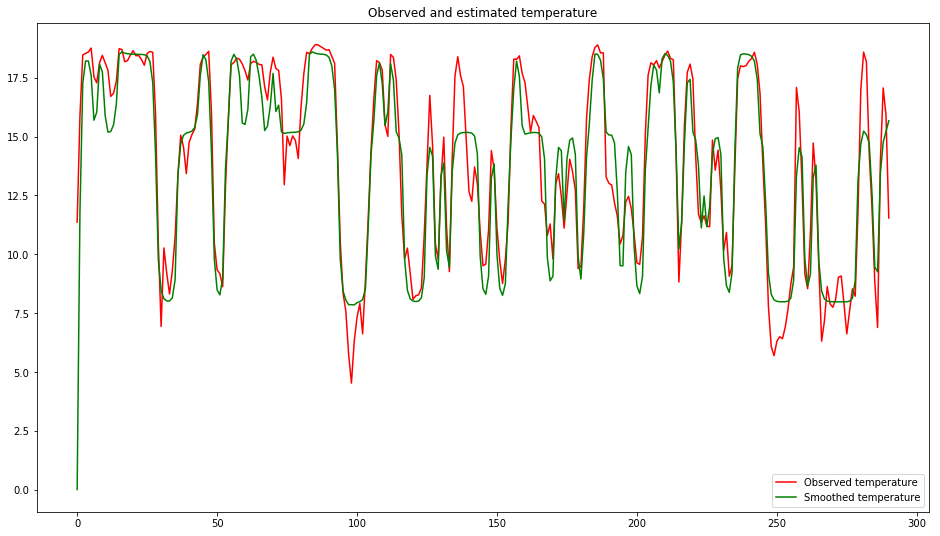

In [119]:
%pylab inline
pylab.rcParams['figure.figsize'] = (16.0, 9.0)

import warnings
warnings.filterwarnings('ignore')

est_temp = x_a.T.dot(np.transpose(gaus_mean[4-K:]))
est_temp2 = x_s.T.dot(np.transpose(gaus_mean[4-K:]))
plot(time, obs,'r', label='Observed temperature')
#plot(time, est_temp,'b', label='Filtered temperature')
plot(time, est_temp2,'g', label='Smoothed temperature')
title('Observed and estimated temperature')
legend()